## FOUNDATION MODEL

In [21]:
import os

In [22]:
%pwd

"c:\\Users\\soulo\\MACHINE_LEARNING_UNIVERSE\\PROJECT'S\\Chest-Cancer-Classification-Using-mlflow-and-DVC\\RESEARCH"

In [23]:
os.chdir('../')
%pwd

"c:\\Users\\soulo\\MACHINE_LEARNING_UNIVERSE\\PROJECT'S\\Chest-Cancer-Classification-Using-mlflow-and-DVC"

In [24]:
## update config.yaml

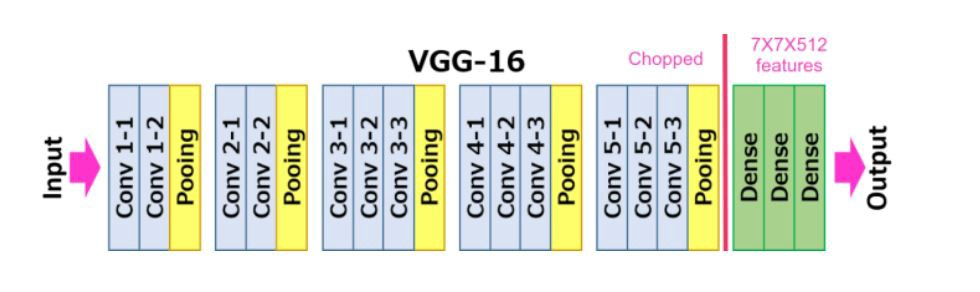

**Arguments**

-   **include_top**: whether to include the 3 fully-connected layers at the top of the network.
-   **weights**: one of  `None`  (random initialization),  `"imagenet"`  (pre-training on ImageNet), or the path to the weights file to be loaded.
-   **input_tensor**: optional Keras tensor (i.e. output of  `layers.Input()`) to use as image input for the model.
-   **input_shape**: optional shape tuple, only to be specified if  `include_top`  is  `False`  (otherwise the input shape has to be  `(224, 224, 3)`  (with  `channels_last`  data format) or  `(3, 224, 224)`  (with  `"channels_first"`  data format). It should have exactly 3 input channels, and width and height should be no smaller than 32. E.g.  `(200, 200, 3)`  would be one valid value.
-   **pooling**: Optional pooling mode for feature extraction when  `include_top`  is  `False`. -  `None`  means that the output of the model will be the 4D tensor output of the last convolutional block. -  `avg`  means that global average pooling will be applied to the output of the last convolutional block, and thus the output of the model will be a 2D tensor. -  `max`  means that global max pooling will be applied.
-   **classes**: optional number of classes to classify images into, only to be specified if  `include_top`  is  `True`, and if no  `weights`  argument is specified.
-   **classifier_activation**: A  `str`  or callable. The activation function to use on the "top" layer. Ignored unless  `include_top=True`. Set  `classifier_activation=None`  to return the logits of the "top" layer. When loading pretrained weights,  `classifier_activation`  can only be  `None`  or  `"softmax"`.

https://keras.io/api/applications/vgg/#vgg16-function

## Update the entity 

In [33]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class PrepareFoundationModelConfig:
    """Configuration for the prepare_foundation_model.py script."""
    root_dir: Path
    base_model_path: Path
    updated_base_model_path: Path
    params_image_size: list
    params_learning_rate: float
    params_include_top: bool
    params_weights: str
    params_classes: int

## Update the configuration manager in src config

In [31]:
from Chest_Cancer_Classification.constants import *
from Chest_Cancer_Classification.utils.common import read_yaml, create_directories

class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])     
        
           
    def get_prepare_foundation_model(self) -> PrepareFoundationModelConfig:
        config = self.config.prepare_foundation_model
        create_directories([config.root_dir])
        
        prepare_foundation_model_config = PrepareFoundationModelConfig(
            root_dir=Path(config.root_dir),
            base_model_path=Path(config.base_model_path),
            updated_base_model_path=Path(config.updated_base_model_path),
            params_image_size=self.params.IMAGE_SIZE,
            params_learning_rate=self.params.LEARNING_RATE,
            params_include_top=self.params.INCLUDE_TOP,
            params_weights=self.params.WEIGHTS,
            params_classes=self.params.CLASSES
        )

        return prepare_foundation_model_config


## Create components

In [27]:
import os 
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf


In [39]:
class PrepareFoundationModel:
    def __init__ (self , config: PrepareFoundationModelConfig):
        self.config = config
        
        
    def get_foundation_model(self):
        self.model = tf.keras.applications.vgg16.VGG16(
            input_shape= self.config.params_image_size,
            weights= self.config.params_weights,
            include_top= self.config.params_include_top
        )
        
        self.save_model(path=self.config.base_model_path , model=self.model)
        
        
    @staticmethod
    def _prepare_full_model(model, classes, freeze_all, freeze_till, learning_rate):
        if freeze_all:
            for _ in model.layers:
                model.trainable = False
        elif (freeze_till is not None) and (freeze_till > 0):
            for _ in model.layers[:-freeze_till]:
                model.trainable = False

        flatten_in = tf.keras.layers.Flatten()(model.output)
        prediction = tf.keras.layers.Dense(
            units=classes,
            activation="softmax")(flatten_in)

        full_model = tf.keras.models.Model(
            inputs=model.input,
            outputs=prediction
        )

        full_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
            loss=tf.keras.losses.CategoricalCrossentropy(),
            metrics=["accuracy"]
        )

        full_model.summary()
        return full_model
    

    def update_base_model(self):
        self.full_model = self._prepare_full_model(
            model=self.model,
            classes=self.config.params_classes,
            freeze_all=True,
            freeze_till=None,
            learning_rate=self.config.params_learning_rate
        )

        self.save_model(path=self.config.updated_base_model_path, model=self.full_model)
    
        
        
    @staticmethod
    def save_model(path: Path , model: tf.keras.Model):
        model.save(path)

## Pipeline

In [40]:
try:
    config = ConfigurationManager()
    prepare_base_model_config = config.get_prepare_foundation_model()
    prepare_base_model = PrepareFoundationModel(config=prepare_base_model_config)
    prepare_base_model.get_foundation_model()
    prepare_base_model.update_base_model()
except Exception as e:
    raise e

[2023-12-03 17:38:16,438: INFO: common: yaml file: config\config.yaml loaded successfully]
[2023-12-03 17:38:16,442: INFO: common: yaml file: params.yaml loaded successfully]
[2023-12-03 17:38:16,443: INFO: common: created directory at: artifacts]
[2023-12-03 17:38:16,444: INFO: common: created directory at: artifacts/prepare_foundation_model]
[2023-12-03 17:38:16,871: WARNING: saving_utils: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 2